# レンタルサイクルの予測

In [146]:
import matplotlib.pyplot as plt
import pandas as pd
from darts import TimeSeries

from darts.models import Prophet
from darts.models import ExponentialSmoothing
from darts.models import LightGBMModel

In [100]:
df = pd.read_csv('./data/day.csv')

In [101]:
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


<Axes: >

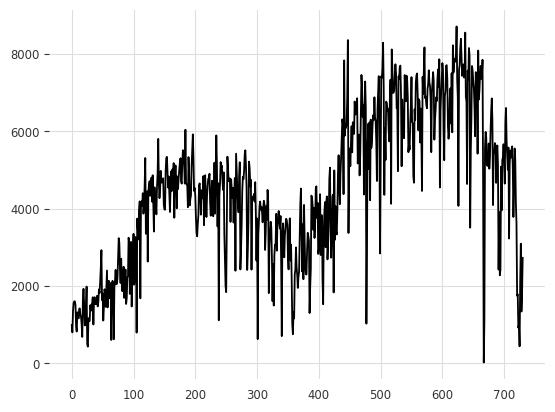

In [102]:
df['cnt'].plot()

<Axes: >

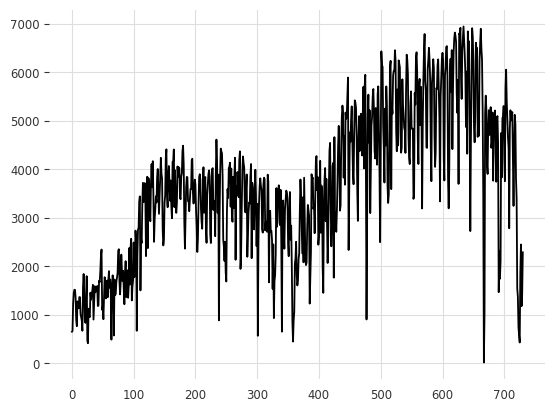

In [103]:
df['registered'].plot()

<Axes: >

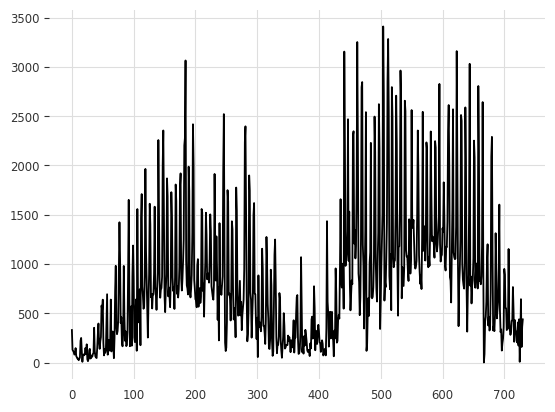

In [104]:
df['casual'].plot()

In [237]:
series = TimeSeries.from_dataframe(df, time_col='dteday', freq='D')

In [238]:
train, test = series[:500], series[496:]

In [139]:
target = train['cnt']
test_target = test['cnt']

In [140]:
cov_columns = ['hum', 'windspeed', 'weekday', 'workingday']
cov = train[cov_columns]
test_cov = test[cov_columns]

In [177]:
model = LightGBMModel(lags=7, output_chunk_length=3, lags_past_covariates=4)

In [178]:
model.fit(target, past_covariates=cov)

LightGBMModel(lags=7, lags_past_covariates=4, lags_future_covariates=None, output_chunk_length=3, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

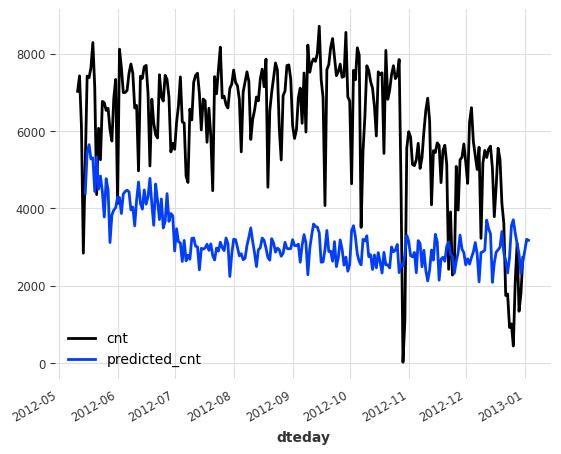

In [188]:
# 共変量を使う場合は単変量を利用する場合と違って未来の値が得られないので、予測先のnが限られる
# testのcovが得られているのであれば学習は可能

test_target.plot()
model.predict(len(test_target)-1, past_covariates=test_cov).plot()
plt.legend(['cnt', 'predicted_cnt'])
plt.show()

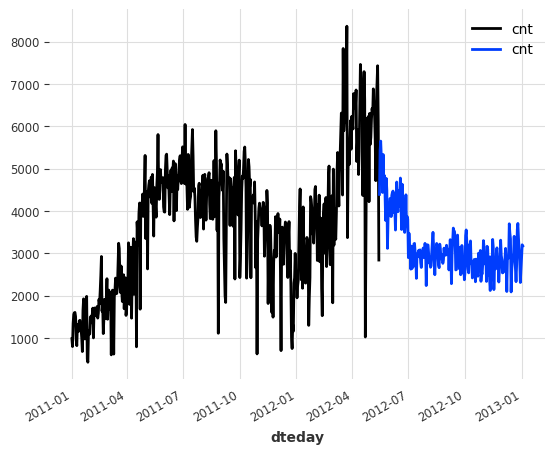

In [192]:
target.plot()
model.predict(len(test_target)-1, past_covariates=test_cov).plot()

In [213]:
from darts.metrics.metrics import mae

In [214]:
model.backtest(train, past_covariates=cov, stride=100, metric=mae)

61.38986902800919

In [149]:
model.model.estimators_

[LGBMRegressor(), LGBMRegressor(), LGBMRegressor()]

In [116]:
single_model = LightGBMModel(lags=5, output_chunk_length=7, lags_past_covariates=4, multi_models=False)

In [117]:
single_model.fit(target, past_covariates=cov)

LightGBMModel(lags=5, lags_past_covariates=4, lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=False, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

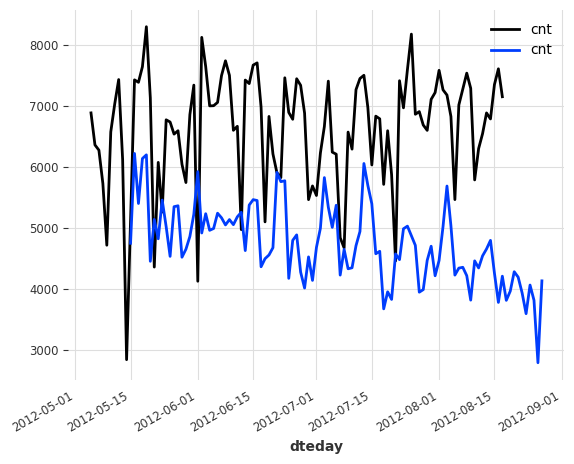

In [118]:
# 共変量を使う場合は単変量を利用する場合と違って未来の値が得られないので、予測先のnが限られる
# testのcovが得られているのであれば学習は可能

test_target[:105].plot()
single_model.predict(105, past_covariates=test_cov).plot()

In [159]:
print(single_model.model, type(single_model.model))

LGBMRegressor() <class 'lightgbm.sklearn.LGBMRegressor'>


## Exponential Smoothing

In [251]:
from darts.models import ExponentialSmoothing

# 後述しますが、モデルの引数でどれくらいの期間を入力とするか（input_chunk_length）、どれくらい先まで予測するのか（output_chunk_length）を定義します。
# デフォルトの場合は、1ステップ先を予測します。
exps = ExponentialSmoothing(seasonal_periods=7)

# fitに渡す変数は単変量の場合自身のみです。
exps.fit(target)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7, random_state=0)

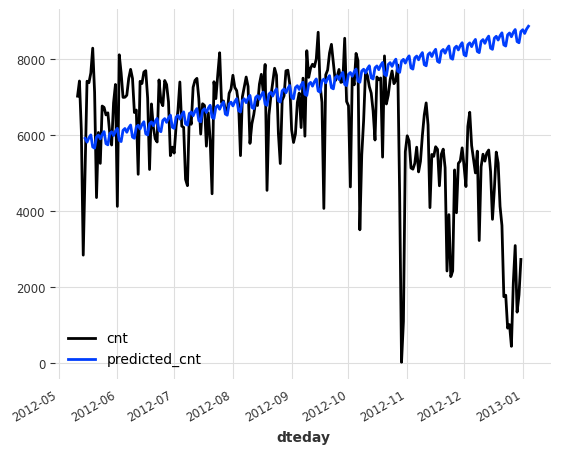

In [201]:
# 共変量を使う場合は単変量を利用する場合と違って未来の値が得られないので、予測先のnが限られる
# testのcovが得られているのであれば学習は可能

test_target.plot()
exps.predict(len(test_target)).plot()
plt.legend(['cnt', 'predicted_cnt'])
plt.show()

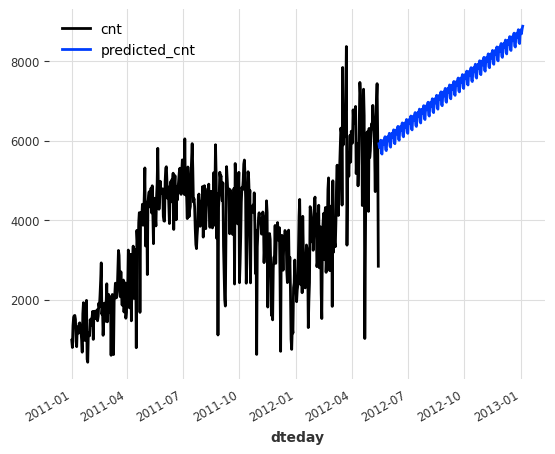

In [217]:
target.plot()
exps.predict(len(test_target)).plot()
plt.legend(['cnt', 'predicted_cnt'])
plt.show()

In [250]:
# 30日の周期だと仮定する場合
exps30 = ExponentialSmoothing(seasonal_periods=30)

# fitに渡す変数は単変量の場合自身のみです。
exps30.fit(target)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=30, random_state=0)

## Transformer

In [229]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing

In [239]:
train, test = series[:500], series[488:]

In [240]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(series)

In [241]:
target = train_scaled['cnt']
test_target = test_scaled['cnt']

cov = train_scaled[cov_columns]
test_cov = test_scaled[cov_columns]

In [233]:
tf_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=3,
    batch_size=32,
    n_epochs=200,
    model_name="bicype_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

In [234]:
tf_model.fit(series=target, past_covariates=cov, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 96    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 23.9 K
6 | decoder             | Linear              | 51    
------------------------------------------------------------
24.0 K    Trainable params
0         Non-trainable params
24.0 K    Total params
0.096     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


TransformerModel(d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=12, output_chunk_length=3, batch_size=32, n_epochs=200, model_name=bicype_transformer, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, force_reset=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

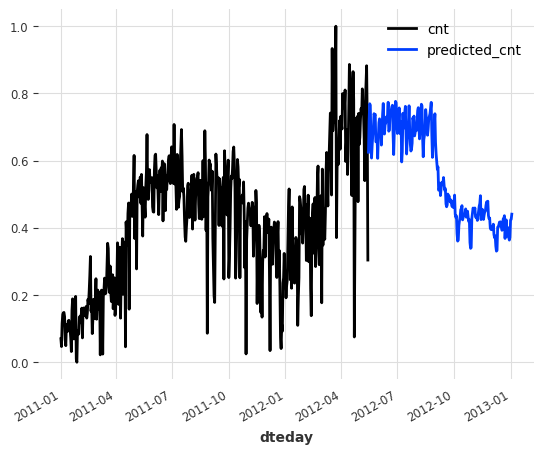

In [248]:
target.plot()
tf_model.predict(len(test_target)-9, past_covariates=test_cov).plot()
plt.legend(['cnt', 'predicted_cnt'])
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

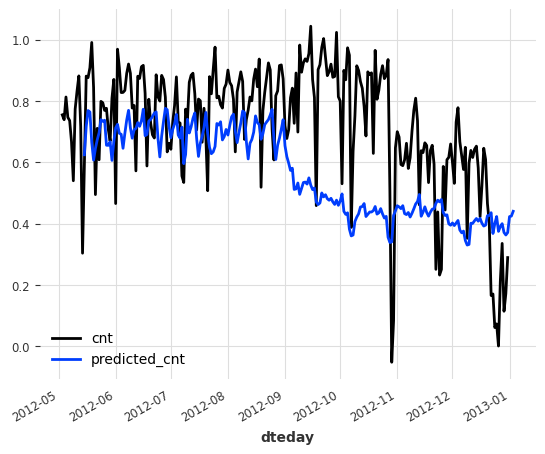

In [249]:
test_target.plot()
tf_model.predict(len(test_target)-9, past_covariates=test_cov).plot()
plt.legend(['cnt', 'predicted_cnt'])
plt.show()